# Assignment 1d Notebook
This notebook builds on the EA code you've written in past assignments to guide you through implementing a multi-objective EA (MOEA). You should copy over the following files from your 1c repository:

* `base_evolution.py`
* `linear_genotype.py`
* `selection.py`

We also recommend that you copy over your notebooks, data, and configs from 1a, 1b, and 1c, as well as the `base_population_evaluation` and `unconstrained_population_evaluation` functions from `stock_population_evaluation.py` **but not the rest of the file**. *Be careful* to not copy over anything else (files you shouldn't have modified anyways). We may have changed them and we want you to have the versions that were provided with this assignment's repo, not the old versions.

Recall that you should be launching this notebook using the `EC-env` conda environment. If you are not in the `EC-env` environment, terminate the notebook server, activate the environment with `conda activate EC-env`, and restart the notebook server.

As usual, be sure to **read all of this notebook**. Start by executing the next cell.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

!pip install snake-eyes-parser
!pip install pytest

import warnings
warnings.filterwarnings('ignore') # hopefully stop any pedantic warnings

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import os
import statistics
from scipy import stats
from snake_eyes import read_config
from linear_genotype import LinearGenotype
from base_evolution import BaseEvolutionPopulation
from cutting_stock.fitness_functions import multiobjective_fitness_function
from stock_population_evaluation import multiobjective_population_evaluation
from multiobjective import dominates, nondomination_sort, assign_fitnesses, calculate_hypervolume
from log_analyzer import analyze_multiobjective_log, format_log
from selection import *

print('The first cell has been executed!')

The first cell has been executed!


## Cutting Stock in Multiple Objectives
It is common for optimization problems to have multiple objectives that need to be optimized. These objectives often conflict with each other to some degree, making it difficult or impossible to find one solution that perfectly optimizes every objective. That is, there are typically *trade-offs* that need to be made between the objectives. Multi-objective optimization is a massive topic that many people have devoted their careers to studying, and not specific to any computational technique. This notebook will only cover the details relevant to a basic MOEA implementation, but a good place to dig into higher-level theory, if you're interested in doing so, is [the Wikipedia page on multi-objective optimization](https://en.wikipedia.org/wiki/Multi-objective_optimization).

For this assignment, we will be optimizing two objectives: minimizing the length (or x-axis) just as before, but now also minimizing the width (or y-axis). We can imagine we know what shapes we want to cut out, but we need to cut these shapes from different stock materials (e.g., aluminum and rubber) available in differing widths. We can buy stock of many possible widths for each material, but they come at different costs. Before deciding what stock to buy, we want to see how much length of stock we would need to use for various widths. We could try running many different runs of our single-objective optimizers from assignments 1a, 1b, or 1c, but this may not be tractable and would require an excess of computational time. Instead, we will use an MOEA that can find optimized layouts for various widths all in one run!

## multiobjective_population_evaluation
We'll start with the fitness function you will be using for this assignment, `multiobjective_fitness_function`. You will use this the same as the previous fitness functions, and it's quite similar to `base_fitness_function` from assignments 1a and 1b. The only difference is it returns two fitness values instead of one, with one representing the length used by a solution (`'length'`), and the other representing the width (`'width'`). Length is exactly the same as `'fitness'` from `base_fitness_function`: length available minus length used for valid solutions, otherwise `failure_fitness` for invalid solutions. Width is calculated analogously, using width instead of length. It also returns the same `'visualize'` you're familiar with.

Execute the following cell to see an example of how to use this function and its outputs.

Output keys: ['length', 'width', 'visualize']
length: -50
width: -50
Solution objective scores: [-50, -50]
The solution looks like:


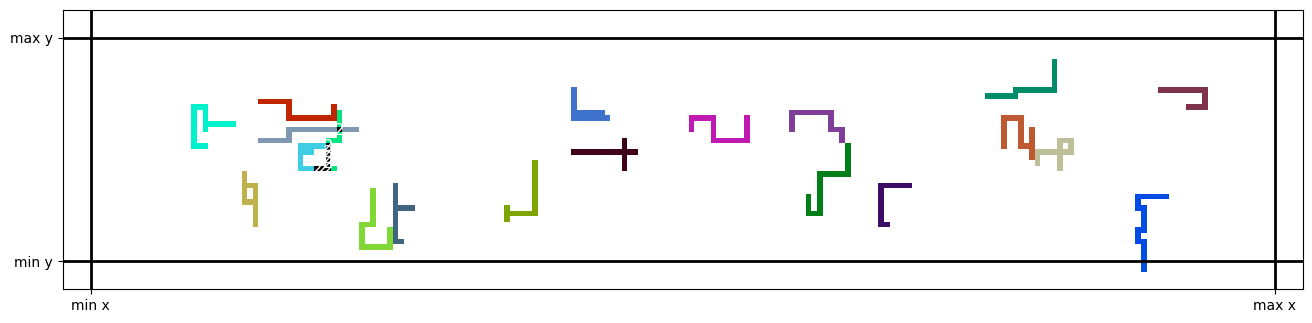

In [3]:
config = read_config('configs/1d_green_no_crowding_config.txt', globals(), locals())

test_solution = LinearGenotype()
test_solution.random_initialization(**config['problem'])

output = multiobjective_fitness_function(test_solution.genes, **config['problem'])
print('Output keys:', [key for key in output.keys()])
print('length:', output['length'])
print('width:', output['width'])

test_solution.objectives = [output['length'], output['width']]
test_solution.visualize = output['visualize']

print('Solution objective scores:', test_solution.objectives)
print('The solution looks like:')
test_solution.visualize()

del config, test_solution, output

Note how we assigned the fitness values into a list as the solution's `objectives` member variable, rather than assigning anything to the `fitness` member variable. It may seem weird that we're calling the fitness function and not assigning a fitness, but just trust that this will all make sense when we're done!

Now that you've seen an example of calling the new fitness function, complete the `multiobjective_population_evaluation` function in `stock_population_evaluation.py`, which populates the `objectives` and `visualize` member variables of all individuals in the input population, just like we did in the previous cell. It should look fairly similar to your `base_population_evaluation` function, but it will call `multiobjective_fitness_function` and assign to the `objectives` member variable rather than `fitness`. Note that length should be the first objective, and width the second objective. After you've implemented the function, run the next cell to test your implementation.

In [4]:
config = read_config('configs/1d_green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(10000, **config['problem'])

# Note explicitly initializing to None is unnecessary in general
# We only do it here to test that you've actually set these values
for individual in example_population:
    individual.objectives = None

# Calling your function to test things out
multiobjective_population_evaluation(example_population, **config['problem'])

unassigned = len([individual.objectives for individual in example_population if individual.objectives is None])

if unassigned == 0:
    lengths = [individual.objectives[0] for individual in example_population]
    print('Best length score:', max(lengths))
    print('Average length score:', statistics.mean(lengths))
    
    widths = [individual.objectives[1] for individual in example_population]
    print('Best width score:', max(widths))
    print('Average width score:', statistics.mean(widths))

else:
    print('Make sure you assign every individual objective scores, then try running this cell again.')

del config, example_population, unassigned

Best length score: 26
Average length score: -49.9728
Best width score: 1
Average width score: -49.9797


## Objectives & Domination
As you can see from your implementation, in a multi-objective optimization problem, we are no longer working with a single unambiguous fitness value. In the past, we could take any two valid solutions and clearly say which one was better, or if they were equivalent, based on comparing their fitnesses. When we're considering two solutions with multiple objectives this is no longer so simple, as there are multiple scores to compare. In the code so far, we haven't even assigned a fitness! So, how do we compare different solutions?

Suppose we have two solutions, $A$ and $B$. We say that $A$ *dominates* $B$ if $A$ is strictly better than $B$ in at least one objective, and not worse than $B$ in any objectives. Then, since there is no objective where $B$ is better, but at least one objective where $A$ is better, we can say that $A$ is a strict improvement over $B$; there is no trade-off or compromise to be made between them.

To reiterate, $A$ dominates $B$ if and only if:

* $A$ is **not** worse than $B$ on *any* objective. Or, equivalently, $A$ is at least as good as $B$ on *all* objectives.
* **AND**
* $A$ is strictly better than $B$ on *any* objective.

The code to implement domination should be pretty simple, using the above bullet points. Now, implement this logic in the `dominates` function in the `multiobjective.py` file. It takes two solutions, `A` and `B`, and returns `True` if `A` dominates `B`, or `False` otherwise. We strongly recommend using the [built-in functions](https://docs.python.org/3/library/functions.html) `any` and `all` to make your algorithm as simple as possible.

The solutions will have already been evaluated by your `multiobjective_population_evaluation` function above, so they will have their `objectives` member variables set already. And remember that, although these are minimization problems, we calculate objective scores such that they should be maximized; bigger is better.

To evaluate your implementation of the `dominates` function, we're going to test your algorithm on an example population. The cell output will point out where your code produced an incorrect result.

In [5]:
example_scores = [[8,2],
                  [4,1],
                  [2,3],
                  [1,2],
                  [9,1],
                  [4,7],
                  [2,5],
                  [1,3],
                  [8,2],
                  [5,5]]

expectation =    [[2,4],
                  [],
                  [4,8],
                  [],
                  [2],
                  [2,3,4,7,8],
                  [3,4,8],
                  [4],
                  [2,4],
                  [2,3,4,7,8]]

config = read_config('configs/1d_green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

print('ID\tDominates')


failed = False
for index in range(len(example_population)):
    domination_list = list()

    for opponent_index in range(len(example_population)):
        if index == opponent_index:
            continue
        if dominates(example_population[index], example_population[opponent_index]):
            domination_list.append(opponent_index + 1)

    print(f'{index + 1}\t{domination_list}', end='')
    if domination_list != expectation[index]:
        print('\tExpected:', expectation[index], end='')
        failed =  True
    print('')

if failed:
    print('At least one of the calls to dominates() was incorrect. ' +\
          'The above table printed the expected output as a third column wherever there was an error.')

del expectation, config, example_population, failed, domination_list

ID	Dominates
1	[2, 4]
2	[]
3	[4, 8]
4	[]
5	[2]
6	[2, 3, 4, 7, 8]
7	[3, 4, 8]
8	[4]
9	[2, 4]
10	[2, 3, 4, 7, 8]


## Nondomination Sort & Pareto Front
In traditional MOEA implementations, such as Non-dominated Sorting Genetic Algorithm II [(NSGA-II)](https://ieeexplore.ieee.org/abstract/document/996017?casa_token=sIy9DHU74qAAAAAA:f9M0Nu6WrHIswdRILFlqhxUqW-rK1nfke65Xw88A1JNX5TaaXZAL76yrC3L8WncdUlrDi25Y7Zo), you would typically implement MOEA-specific selection operators that use the different objective scores directly in their selection process. For example, you might do `k`-tournaments by sampling `k` contestants, determining which of the `k` contestants are not dominated by any other contestants, and selecting one of these non-dominated contestants. This works because `k`-tournament selection is a rank-based algorithm, only relying on relative comparisons between individuals (more fit, less fit, or equally-fit). However, not all selection algorithms work this way - for example, fitness-proportional selection requires numeric values that are proportional to fitness.

Rather than having you write MOEA-specific selection algorithms, we will instead use a nonstandard technique (specific to this class, not drawn from EC literature or tradition) that utilizes dominance relationships to assign each individual in your population a single representative fitness value, which lets you re-use your existing selection algorithms. This technique is based on performing a *nondomination sort*, which is a well-established process in the literature. In fact, you can find a very detailed description of a nondomination sorting algorithm (along with pseudocode) in the NSGA-II paper linked above.

A nondomination sort takes the entire population, where every solution has already been evaluated, and places each one into a *level of nondomination*. This essentially represents how much a solution is dominated by other solutions. The set of solutions that are not dominated by any others is called the [*Pareto front*](https://en.wikipedia.org/wiki/Pareto_front); following from the definition of dominance, we can interpret these as the most optimal (or "best") solutions in the population. You may see references in literature using the term Pareto front to refer to the theoretically optimal set of solutions, but we use it to mean the best that you've found so far. The second level of nondomination consists of the solutions that are exclusively dominated by solutions on the Pareto front, the third level is the solutions exclusively dominated by solutions on the second level or the Pareto front, etc. Each level of nondomination consists of solutions dominated exclusively by solutions from superior levels of nondomination. If this is a bit hard to understand in text, this process was described extensively during a class lecture.

Now that we understand the terminology, our technique can be summarised in 4 steps:

1. Evaluate new individuals, assigning objective scores to each one.
2. Sort the population into levels of nondomination, where level `1` is the Pareto front, and successive levels are `1` plus the previous level (`2`, then `3`, then `4`, etc.). Assign each individual's level to its `level` member variable.
3. Calculate a fitness representing the levels of nondomination as `max_level + 1 - individual.level`, where `max_level` is the final level of nondomination. This leaves individuals on the Pareto front with fitness `max_level`, then the next level has fitness `max_level - 1`, then `max_level - 2`, etc., down to `1` for the final level. Assign this to the `fitness` member variable.
4. OPTIONAL: Subtract a crowding penalty in the range `[0, 1)` from each individual's fitness (we'll explain this later in the notebook!)

This technique, which you will soon finish implementing, yields comparisons equivalent to the NSGA-II comparison operators. Selection thus behaves similarly when using any of our rank-based selection algorithms (i.e., `k`-tournaments with or without replacement, and truncation), but additionally works with fitness-proportionate selection algorithms (i.e., FPS and SUS), though using such selection algorithms in an MOEA is practically nonexistent in literature.

You've already written the code to do step 1, `multiobjective_population_evaluation`. You've also completed the first component of step 2, `dominates`. We've provided a function for you that does step 3, so there are two functions remaining before you can assemble your MOEA.

## Assigning Levels of Nondomination
You now need to implement the `nondomination_sort` function in `multiobjective.py`, which uses the `dominates` function to sort your population into levels of nondomination and assigns each one a `level` member variable calculated as described above. This is a fairly complex operation, and you're free to implement it however you wish (including the addition of new functions to aid readability), so long as it produces the expected results. It should assign every individual a `level` member variable (step 2 above), but they should still have no `fitness` value.

We'll evaluate your `nondomination_sort` implementation using the same example we used to evaluate `dominates`. Again, the cell will point out anywhere your code produces an incorrect result.

In [6]:
expectation = [[1,5,6,9,10],
               [2,7],
               [3],
               [8],
               [4]]

config = read_config('configs/1d_green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

    # Setting level to None to test your implementation
    example_population[index].level = None

# Calling your function to test things out
nondomination_sort(example_population)

if any([individual.fitness is not None for individual in example_population]):
    print('Make sure you do NOT assign fitness values, then try running this cell again.')

elif any([individual.level is None for individual in example_population]):
    print('Make sure you assign every individual a level value, then try running this cell again.')

else:
    levels = {individual.level for individual in example_population}
    levels = sorted(levels)

    expected_levels = list(range(1, len(expectation) + 1))
    if levels != expected_levels:
        print('Make sure your level values are correct.\n' +\
              f'They should be {expected_levels}, but yours were {levels}.')

    else:
        print('Level\tElements')
        for index in range(len(levels)):
            members = [i + 1 for i in range(len(example_population)) if example_population[i].level == levels[index]]
            members = sorted(members)
            print(f'{index + 1}\t{members}', end = '')
            if members != expectation[index]:
                print('\tExpected:', expectation[index], end = '')
            print('')

    del levels, expected_levels

del expectation, config, example_population

Level	Elements
1	[1, 5, 6, 9, 10]
2	[2, 7]
3	[3]
4	[8]
5	[4]


## Calculating Representative Fitness
With levels assigned, we've finished step 2 of our technique. We have provided the `assign_fitnesses` function in `multiobjective.py` for you, which will use your `nondomination_sort` implementation to assign representative fitnesses to the population. The following cell will use the same example as before to show the fitness values this function calculates.

In [7]:
expectation = [5, 4, 3, 1, 5, 5, 4, 2, 5, 5]

config = read_config('configs/1d_green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

    # Setting level to None to test your implementation
    example_population[index].level = None

assign_fitnesses(example_population, **config['problem'])

if any([individual.fitness is None for individual in example_population]):
    print('Make sure you assign every individual a fitness value, then try running this cell again.')

elif any([individual.level is None for individual in example_population]):
    print('Make sure you assign every individual a level value, then try running this cell again.')

else:
    failed = False
    print('Element\tFitness')
    for index in range(len(example_population)):
        fitness = example_population[index].fitness
        print(f'{index+1}\t{fitness}', end='')
        if fitness != expectation[index]:
            print(f'\expected{expectation[index]}')
            failed = True
        else:
            print()

    if failed:
        print('Something has gone wrong. Perhaps your nondomination sort has a bug.')

    del fitness, failed

del expectation, config, example_population

Element	Fitness
1	5
2	4
3	3
4	1
5	5
6	5
7	4
8	2
9	5
10	5


## Crowding
Now, for the very final thing to implement before you assemble the MOEA: crowding. A big problem for MOEAs is that it can become easy for many solutions to occupy a very small amount of space on the Pareto front, causing your EA to waste a lot of evaluations exploring in a very small part of the fitness landscape. That is, if we treat all individuals on each level of nondomination as equals, then, if the majority of those individuals are concentrated in one spot, we spend the majority of our time exploring around that spot. This can then lead to even more solutions in that area, making the problem worse and worse every generation. Here's a visualization that might help you understand the problem, from [a paper by Yue *et al.*](https://doi.org/10.1016/j.swevo.2021.100849):

<div>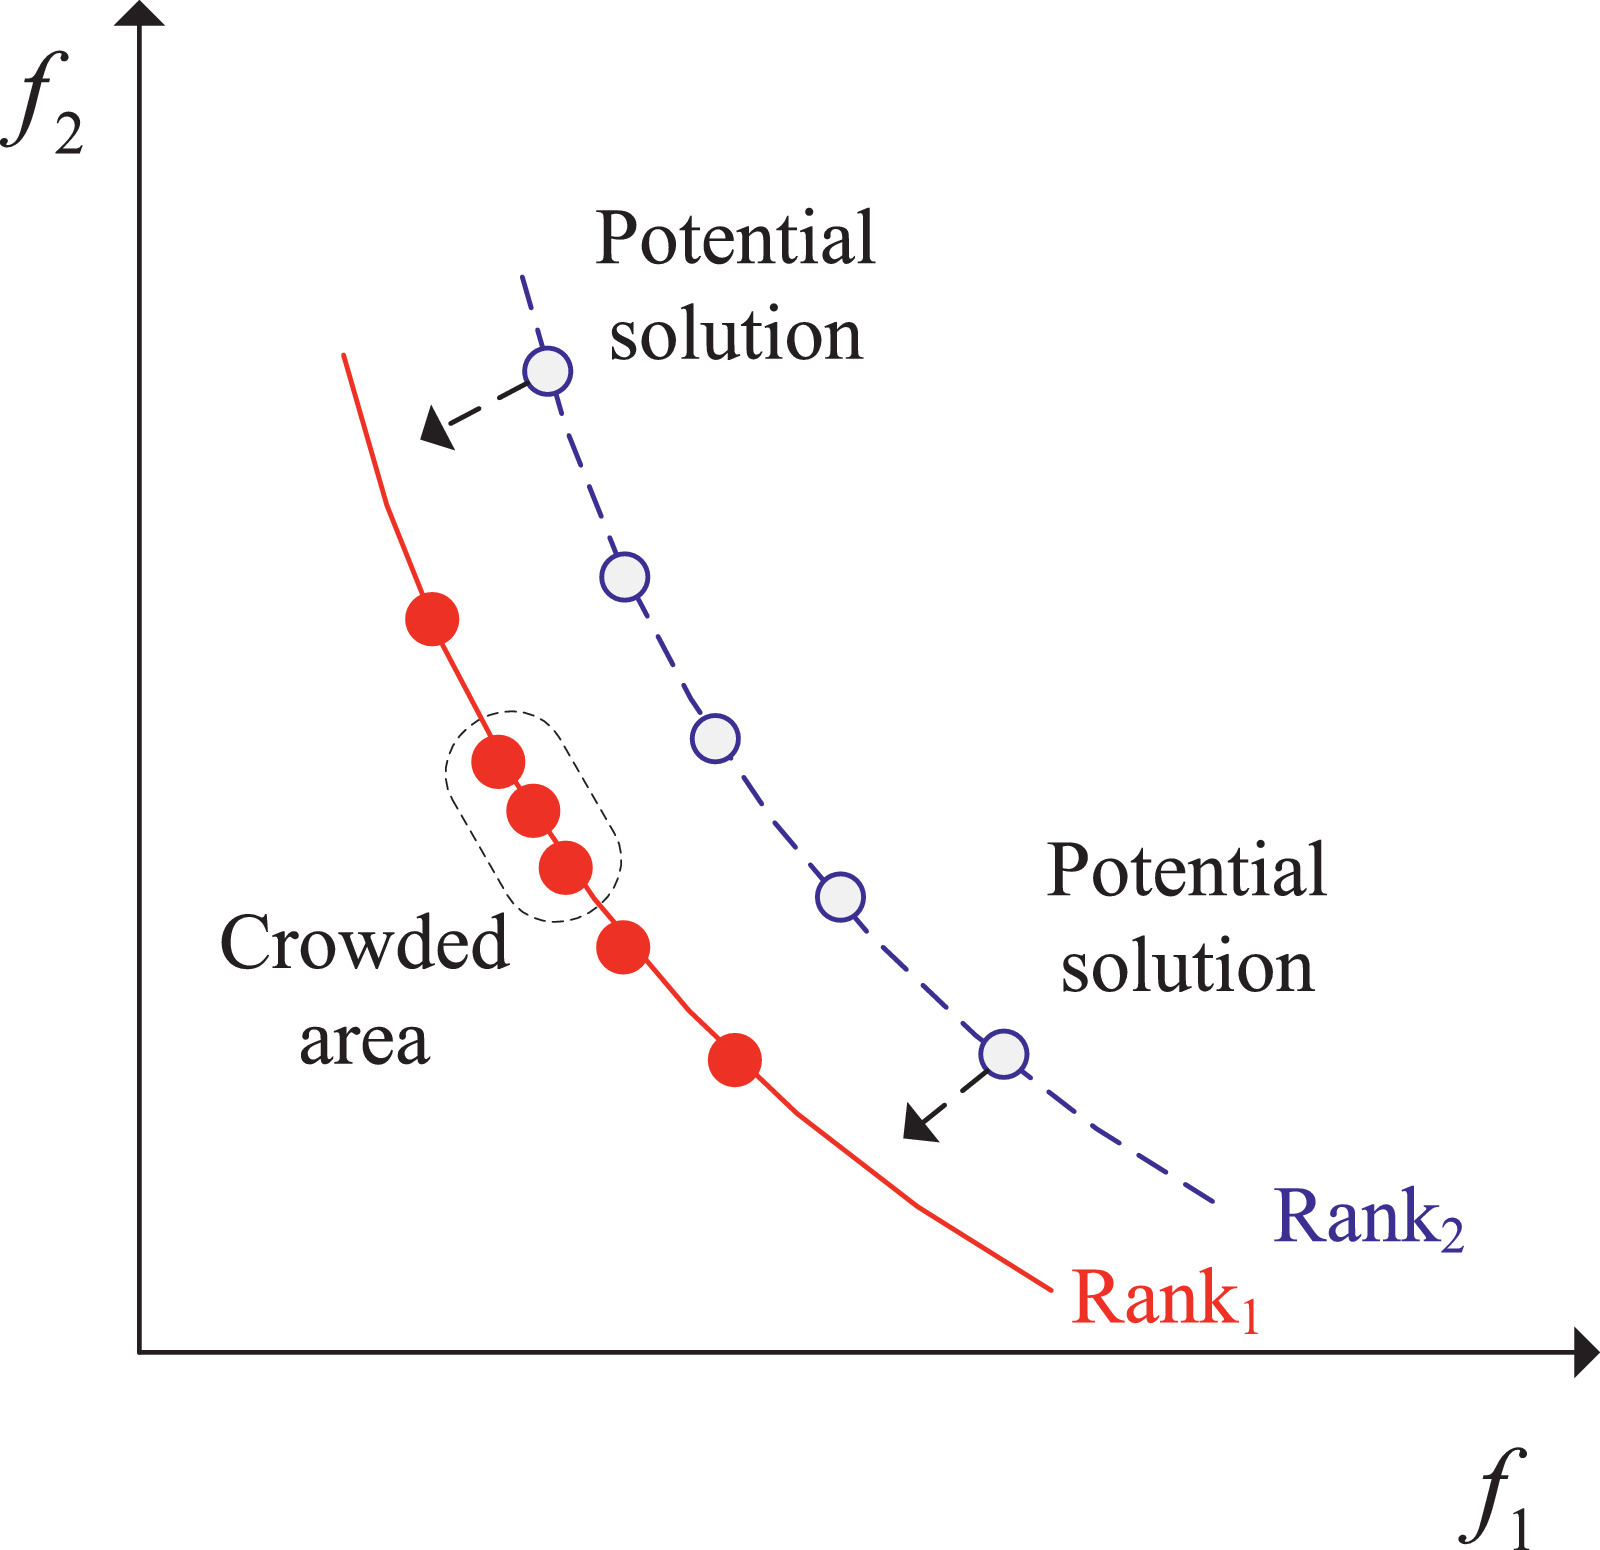</div>

Note that this visualization is formulated as trying to *minimize* objective scores, which is fairly common in the literature, but the opposite of how we are calculating objectives in this assignment series. But the overall idea still holds: while there is good reason to search around the crowded area, there may be the potential for greater improvements elsewhere. The entire point of an MOEA is to find a diverse range of solutions, so our current approach obviously has some shortcomings. MOEAs typically get around this problem by implementing *crowding*.

We require that you implement the improved crowding distance algorithm from the NSGA-II paper [(same link as before for convenience)](https://ieeexplore.ieee.org/abstract/document/996017?casa_token=sIy9DHU74qAAAAAA:f9M0Nu6WrHIswdRILFlqhxUqW-rK1nfke65Xw88A1JNX5TaaXZAL76yrC3L8WncdUlrDi25Y7Zo) in the `assign_crowding_distances` function of `multiobjective.py`. This function takes the entire population and assigns each individual's crowding distance to a `crowding` member variable. There are three important implementation details to highlight:

1. You *must* use the `inf` constant from the `math` module to represent infinity. The first line of `multiobjective.py` imports `inf` for you already.
2. You need to account for possible division by zero. Whenever you would divide by zero, instead use `inf` as the result (i.e., replace `x/0` with `inf`).
3. There can be multiple individuals that count as being "on the boundary" of an objective, i.e., there can be multiple solutions that have the same minimal/maximal objective score. When this is the case, it is sufficient to consider the boundaries to be the first element and the last element of the sort (i.e., arbitrarily pick a minimal and a maximal solution).

Implement the `assign_crowding_distances` function before reading further. We will test it in the next code cell.

NSGA-II utilizes the crowding distance as a way to discriminate between individuals on the same level of nondomination (i.e., it is a tie-breaker). Since we've used integers as a way to represent levels of nondomination in our MOEA implementation, we can use crowding in a similar way to NSGA-II by calculating a crowding penalty for each individual in the range `[0, 1)` and subtracting this from its representative fitness. This ensures that all individuals on each level still have a greater fitness than any of the solutions on subsequent levels. That is, it serves as a way to discriminate between individuals on the same level, just as in NSGA-II.

We already implemented the code to apply this penalty for you; if your `assign_crowding_distances` function is correct, then the crowding penalty should work already. The following cell will test your implementation on the same example we've been working with previously. Note that there is an assertion in the `assign_fitnesses` function that will fail if your `assign_crowding_distances` function returns values outside of the valid range. The crowding distance calculation is somewhat implementation-specific (namely, how you sort solutions with the same objective score) so we can't really test your code. However, running the following cell with our implementation prints the following crowding distances:

`[0.7666666666666666, inf, inf, inf, inf, inf, inf, inf, 0.7, 1.6333333333333333]`

And the following fitnesses:

`[4.38295, 4, 3, 1, 5, 5, 4, 2, 4.3496500000000005, 4.81585]`

The `0.766...` and the `0.7` distances might be swapped in your implementation, but your results should be reasonably similar to this.

In [8]:
from math import inf

config = read_config('configs/1d_green_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

    # Setting crowding to None to test your implementation
    example_population[index].crowding = None

assign_fitnesses(example_population, **config['problem'])

if any([individual.crowding is None for individual in example_population]):
    print('Make sure you assign every individual a crowding value, then try running this cell again.')

print('Crowding distances:')
print([ind.crowding for ind in example_population])

print('Fitnesses:')
print([ind.fitness for ind in example_population])

Crowding distances:
[0.7666666666666666, inf, inf, inf, inf, inf, inf, inf, 0.7, 1.6333333333333333]
Fitnesses:
[4.38295, 4, 3, 1, 5, 5, 4, 2, 4.3496500000000005, 4.81585]


## Analyzing Multi-objective Performance
Comparing multi-objective performance is a lot more involved than the analysis you've done so far. Particularly, **our representative fitness calculated based on levels of nondomination is entirely meaningless for analysis** and generally not worth reporting at all. An individual's `fitness` only has meaning in the context of the exact population that it was sorted into, and the maximum `fitness` in a population has absolutely nothing to do with how well your MOEA has optimized the objectives. So, how do we analyze performance?

One common approach is to use a [hypervolume calculation](https://lopez-ibanez.eu/hypervolume), which essentially measures the "area under the curve" of your Pareto front's objective scores. In practice this is often an approximation, calculated by incredibly complicated algorithms that researchers devote years to perfecting. While it would be great fun to have you implement such an algorithm, we've provided a function to do it for you. Our calculation is exact (not an approximation), so you'll consistently get the same results. As an implementation detail, we calculate our hypervolumes in two objectives with a reference point of $(-1, -1)$, as the lowest possible score for a valid solution is $0$ in each objective.

You can get the hypervolume using the `calculate_hypervolume` function we've provided. This function takes a Pareto front as input, and returns a number representing the Pareto front's hypervolume. The following cell shows off an example of how to use this function, with the same example problem as the previous cells. Also, read the code carefully to see an example of how to get the Pareto front from a population. This will be necessary when you implement your MOEA! This cell will also visualize the Pareto front to help show you the hypervolume.

The hypervolume of the Pareto front is: 57
Pareto front scores: [[4, 7], [5, 5], [8, 2], [8, 2], [9, 1]]


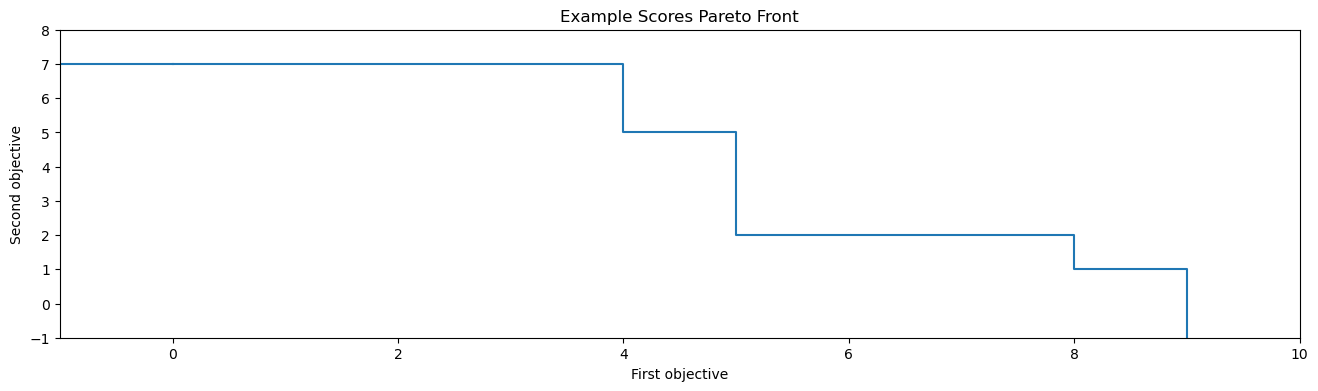

In [9]:
def plot_pareto_front(pareto_scores, title):
    # Matplotlib's stairs function has some unwanted behavior, so we do this manually.
    # It's a bit gross, but that's how custom matplotlib stuff often ends up...
    pareto_scores = sorted(pareto_scores, key=lambda score:score[0])
    pareto_y = []
    y_index = 0
    max_length = max(score[0] for score in pareto_scores)
    max_width = max(score[1] for score in pareto_scores)
    for x in range(max_length + 1):
        while x > pareto_scores[y_index][0]:
            y_index += 1
        pareto_y.append(pareto_scores[y_index][1])
    pareto_y.append(-2)

    fig, ax = plt.subplots()
    ax.set(xlabel = 'First objective', ylabel = 'Second objective', title=title,
           xlim = [-1, max_length + 1], ylim = [-1, max_width + 1])
    ax.plot(pareto_y, drawstyle='steps-pre')
    ax.axhline(pareto_y[0], -1, 1/(max_length + 2))

    plt.show()

config = read_config('configs/1d_green_no_crowding_config.txt', globals(), locals())

example_population = LinearGenotype.initialization(len(example_scores), **config['problem'])

for index in range(len(example_population)):
    # Assigning objectives directly, rather than using
    # multiobjective_population_evaluation, for demo purposes only
    example_population[index].objectives = example_scores[index]

# Use assign_fitnesses to assign fitnesses & levels of nondomination
assign_fitnesses(example_population, **config['problem'])

# Determine who is on the Pareto front
pareto_front = [individual for individual in example_population if individual.level == 1]

# Calculate the hypervolume
hypervolume = calculate_hypervolume(pareto_front)

# Print for this tutorial
print('The hypervolume of the Pareto front is:', hypervolume)

# Plot the hypervolume for this tutorial
# The code here is unimportant, just focus on the plot it produces
front_scores = [individual.objectives for individual in pareto_front]
print('Pareto front scores:', sorted(front_scores, key=lambda x:x[0]))
plot_pareto_front(front_scores, 'Example Scores Pareto Front')

del config, example_population, pareto_front, plot_pareto_front

In [92]:
# Clean up the example we've been using
del example_scores

Even though this is a minimization problem, the objective scores have been designed as values to be maximized, just as in the past assignments. Therefore, a greater hypervolume implies better performance. With the hypervolumes, you can conduct a t-test and interpret the results similarly as your past experiments. That is, **use the hypervolume calculated from the Pareto front from each run's final generation the same way you used the best fitness seen during a run in past assignments**. While in practice you would want to keep track of the *globally* nondominated solutions (i.e., Pareto front) during a run, similar to how you were told to use *global* best fitness in the past, we will accept simply using the *local* nondominated solutions (Pareto front) from the final generation, even with a nonelitist parameter configuration.

We also require that you log the hypervolume dominated by the local Pareto front at the end of each generation (including the initial population), in order to plot this value versus evaluation count. Since the hypervolume is the metric we are using to measure your MOEA's progress, this is similar to plotting the best fitness versus evaluations like you did in past assignments.

## Assembling the MOEA
Using the `multiobjective_population_evaluation` and `assign_fitnesses` functions, you can assemble your complete MOEA using the `BaseEvolutionPopulation` population class you implemented in Assignment 1b. There are, however, some small differences from a single-objective EA that we'll walk you through in the following example.

In [99]:
config = read_config('configs/1d_green_crowding_config.txt', globals(), locals())

# Full initialization of your EA
example_ea = BaseEvolutionPopulation(**config['ea'], **config)

# Evaluate the initial population
multiobjective_population_evaluation(example_ea.population, **config['problem'])

# Count evaluations for initial population
example_ea.evaluations = len(example_ea.population)

# Print for tutorial purposes
print('Number of fitness evaluations:', example_ea.evaluations)

Number of fitness evaluations: 5


Until this point, the EA looks as expected. We've read a config, initialized the EA, and evaluated the initial population. Recall, however, that the evaluation function only assigns objective scores that can't directly be used as single-value fitness in evolution. To calculate a single fitness value and evolve as usual, we have to add a call to `assign_fitnesses` **before the generational loop**. Immediately after this is where you should log data for the initial population:

In [100]:
# Sort population and assign representative fitnesses
assign_fitnesses(example_ea.population, **config['problem'])

# Add values to the log after the initial generation
example_ea.log.append(f'Evaluations: {example_ea.evaluations}')
example_ea.log.append(f'Local best length: {max(map(lambda x:x.objectives[0], example_ea.population))}')
example_ea.log.append(f'Local mean length: {statistics.mean(map(lambda x:x.objectives[0], example_ea.population))}')
example_ea.log.append(f'Local best width: {max(map(lambda x:x.objectives[1], example_ea.population))}')
example_ea.log.append(f'Local mean width: {statistics.mean(map(lambda x:x.objectives[1], example_ea.population))}')
pareto_front = [individual for individual in example_ea.population if individual.level == 1]
hypervolume = calculate_hypervolume(pareto_front)
example_ea.log.append(f'Individuals in the Pareto front: {len(pareto_front)}')
example_ea.log.append(f'Local Pareto front mean length: {statistics.mean(map(lambda x:x.objectives[0], pareto_front))}')
example_ea.log.append(f'Local Pareto front mean width: {statistics.mean(map(lambda x:x.objectives[1], pareto_front))}')
example_ea.log.append(f'Local Pareto front hypervolume: {hypervolume}')

Now, with fitnesses assigned to the initial population, we can begin our generational loop as usual:

In [101]:
# Generate children
children = example_ea.generate_children()

# Evaluate children
multiobjective_population_evaluation(children, **config['problem'])

# Update evaluation count
example_ea.evaluations += len(children)

# Add children to the population
example_ea.population += children

# Print for tutorial purposes
print('Number of fitness evaluations:', example_ea.evaluations)

Number of fitness evaluations: 10000


Now, with the children added, the population has changed. Recall that our representative fitness is based on levels of nondomination, and levels of nondomination depend on the entire population. Therefore, **you need to re-sort the *entire* population and re-calculate representative fitnesses** (via `assign_fitnesses`) **every time the population changes. However, inside your generational loop, you should still only evaluate the children** (via `multiobjective_population_evaluation`), **not the entire population.** Objective scores returned by the evaluation function will always be the same for the same solution, *but its representative fitness value may change whenever the population does*.

In [102]:
# Re-sort population with children and assign representative fitness
assign_fitnesses(example_ea.population, **config['problem'])

With fitnesses recalculated after the children were added, we can perform survival selection as usual:

In [103]:
# Perform survival selection
example_ea.survival()

Survival selection has changed the population, so we need to re-calculate fitnesses yet again. This is also where we should log data for the current generation.

In [104]:
# Re-sort surviving population and assign representative fitness
assign_fitnesses(example_ea.population)

# Add values to the log after the current generation
example_ea.log.append(f'Evaluations: {example_ea.evaluations}')
example_ea.log.append(f'Local best length: {max(map(lambda x:x.objectives[0], example_ea.population))}')
example_ea.log.append(f'Local mean length: {statistics.mean(map(lambda x:x.objectives[0], example_ea.population))}')
example_ea.log.append(f'Local best width: {max(map(lambda x:x.objectives[1], example_ea.population))}')
example_ea.log.append(f'Local mean width: {statistics.mean(map(lambda x:x.objectives[1], example_ea.population))}')
pareto_front = [individual for individual in example_ea.population if individual.level == 1]
hypervolume = calculate_hypervolume(pareto_front)
example_ea.log.append(f'Individuals in the Pareto front: {len(pareto_front)}')
example_ea.log.append(f'Local Pareto front mean length: {statistics.mean(map(lambda x:x.objectives[0], pareto_front))}')
example_ea.log.append(f'Local Pareto front mean width: {statistics.mean(map(lambda x:x.objectives[1], pareto_front))}')
example_ea.log.append(f'Local Pareto front hypervolume: {hypervolume}')

In [ ]:
# Delete variables to prevent accidental misuse
del example_ea, children, pareto_front, hypervolume

The three calls to `assign_fitnesses` (after evaluating the initial population, after adding children to the population, and after survival selection) are new additions, but otherwise the MOEA function should closely resemble the EA functions of assignments 1b and 1c. Also note the new lines for logging and where they are placed.

Now that you've implemented the necessary functions and the MOEA cycle has been demonstrated, assemble your MOEA in the following cell.

In [173]:
def multiobjective_EA_search(number_evaluations, config_filename):
    gen_data = []
    run_data = []
    # Parse the config and implement your multiobjective EA here.
    # Feel free to focus on implementation first and then return for data collection.
    config = read_config(config_filename, globals(), locals())
    ea = BaseEvolutionPopulation(**config['ea'], **config)
    multiobjective_population_evaluation(ea.population, **config['problem'])
    ea.evaluations = len(ea.population)
    # Sort population and assign representative fitnesses
    assign_fitnesses(ea.population, **config['problem'])
    
    # Add values to the log after the initial generation
    temp_evals = ea.evaluations
    temp_lb_length = max(map(lambda x:x.objectives[0], ea.population))
    temp_lm_length = statistics.mean(map(lambda x:x.objectives[0], ea.population))
    temp_lb_width = max(map(lambda x:x.objectives[1], ea.population))
    temp_lm_width = statistics.mean(map(lambda x:x.objectives[1], ea.population))
    pareto_front = [individual for individual in ea.population if individual.level == 1]
    hypervolume = calculate_hypervolume(pareto_front)
    temp_pf_individuals = len(pareto_front)
    temp_pf_ml = statistics.mean(map(lambda x:x.objectives[0], pareto_front))
    temp_pf_mw = statistics.mean(map(lambda x:x.objectives[1], pareto_front))
    
    ea.log.append(f'Evaluations: {temp_evals}')
    ea.log.append(f'Local best length: {temp_lb_length}')
    ea.log.append(f'Local mean length: {temp_lm_length}')
    ea.log.append(f'Local best width: {temp_lb_width}')
    ea.log.append(f'Local mean width: {temp_lm_width}')
    ea.log.append(f'Individuals in the Pareto front: {temp_pf_individuals}')
    ea.log.append(f'Local Pareto front mean length: {temp_pf_ml}')
    ea.log.append(f'Local Pareto front mean width: {temp_pf_mw}')
    ea.log.append(f'Local Pareto front hypervolume: {hypervolume}')
    
    gen_data.append(
        (
            temp_evals,
            temp_lb_length,
            temp_lm_length,
            temp_lb_width,
            temp_lm_width,
            hypervolume
        )
    )
    
    while (ea.evaluations < number_evaluations):
        #print(ea.evaluations)
        children = ea.generate_children()
        multiobjective_population_evaluation(children, **config['problem'])
        
        ea.evaluations += len(children)
        ea.population += children
        assign_fitnesses(ea.population, **config['problem'])
        
        ea.survival()
        assign_fitnesses(ea.population, **config['problem'])
    
        # Add values to the log after the initial generation
        temp_evals = ea.evaluations
        temp_lb_length = max(map(lambda x:x.objectives[0], ea.population))
        temp_lm_length = statistics.mean(map(lambda x:x.objectives[0], ea.population))
        temp_lb_width = max(map(lambda x:x.objectives[1], ea.population))
        temp_lm_width = statistics.mean(map(lambda x:x.objectives[1], ea.population))
        pareto_front = [individual for individual in ea.population if individual.level == 1]
        hypervolume = calculate_hypervolume(pareto_front)
        temp_pf_individuals = len(pareto_front)
        temp_pf_ml = statistics.mean(map(lambda x:x.objectives[0], pareto_front))
        temp_pf_mw = statistics.mean(map(lambda x:x.objectives[1], pareto_front))

        ea.log.append(f'Evaluations: {temp_evals}')
        ea.log.append(f'Local best length: {temp_lb_length}')
        ea.log.append(f'Local mean length: {temp_lm_length}')
        ea.log.append(f'Local best width: {temp_lb_width}')
        ea.log.append(f'Local mean width: {temp_lm_width}')
        ea.log.append(f'Individuals in the Pareto front: {temp_pf_individuals}')
        ea.log.append(f'Local Pareto front mean length: {temp_pf_ml}')
        ea.log.append(f'Local Pareto front mean width: {temp_pf_mw}')
        ea.log.append(f'Local Pareto front hypervolume: {hypervolume}')

        gen_data.append(
            (
                temp_evals,
                temp_lb_length,
                temp_lm_length,
                temp_lb_width,
                temp_lm_width,
                hypervolume
            )
        )
    pareto_front = [individual for individual in ea.population if individual.level == 1] 
    run_data.append(
        (
            pareto_front,
            [individual.objectives for individual in pareto_front]
        )
    )
    # Load this with your BaseEvolutionPopulation's log member after the run.
    log = ea.log

    # This will print outputs if it looks like anything has gone wrong.
    analyze_multiobjective_log(log, number_evaluations)

    # Return whatever data you wish!
    return log, gen_data, run_data

1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
85000
8550

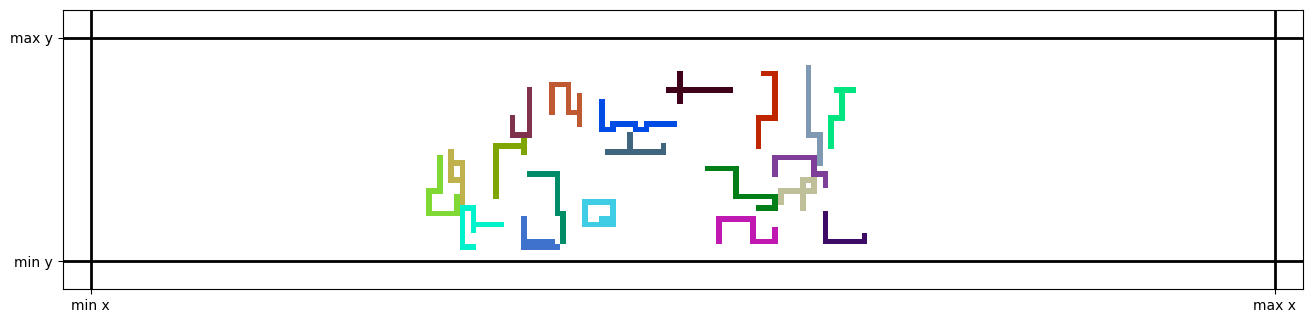

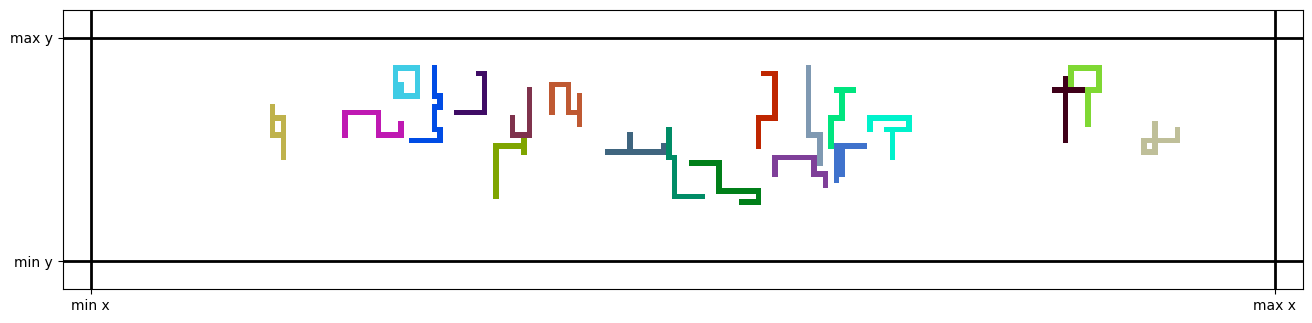

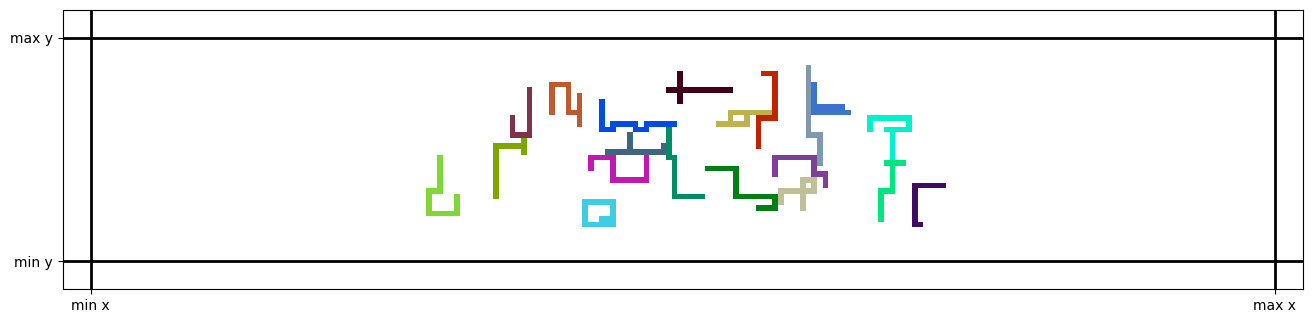

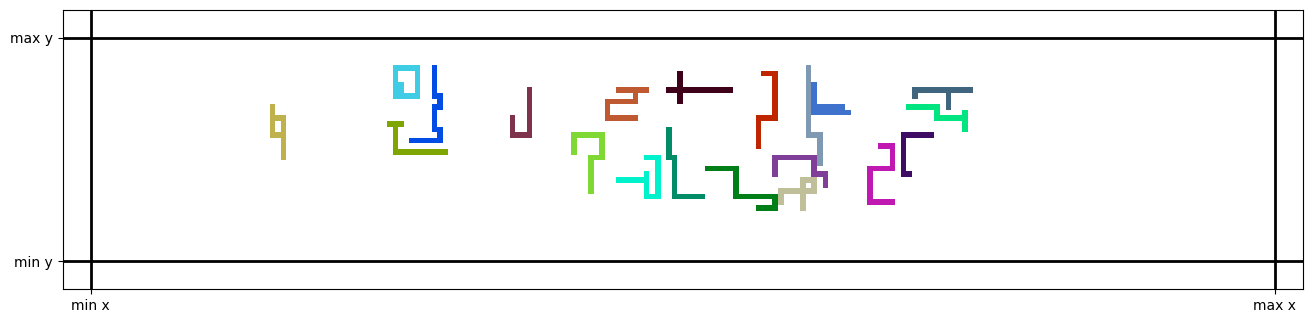

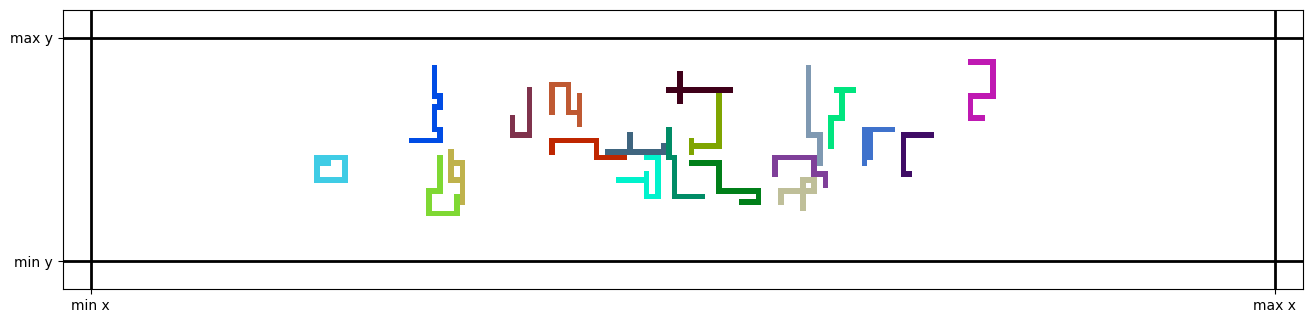

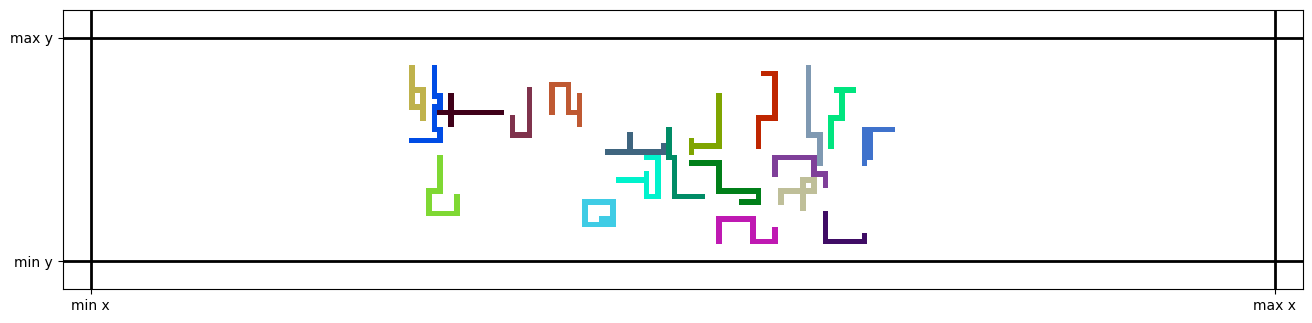

In [172]:
# Calling one run of your MOEA with crowding
output = multiobjective_EA_search(100_000, 'configs/1d_green_crowding_config.txt')
print(output)
test = output[1]
print(test)
for each in output[2][0][0][:10]:
    each.visualize()

## Tuning
We have no specific requirements for tuning your MOEAs, but we still encourage you to use the following cells to explore the parameter space at least a little bit. You may want to use your 1b configuration as a starting point.

In [ ]:
tuning_runs = 5
number_evaluations = 100_000
config_filename = 'configs/1d_green_no_crowding_config.txt'

# Sample function call:
# multiobjective_EA_search(number_evaluations, config_filename)

# Conduct multi-run tuning experiments here (make sure to upload your tuned 1d_green_no_crowding_config with your assignment)


In [ ]:
tuning_runs = 5
number_evaluations = 100_000
config_filename = 'configs/1d_green_crowding_config.txt'

# Sample function call:
# multiobjective_EA_search(number_evaluations, config_filename)

# Conduct multi-run tuning experiments here (make sure to upload your tuned 1d_green_crowding_config with your assignment)


## Experiment
Now that you've tested an implementation of a single run, implement code to perform two experiments, each with 30 runs of your MOEA search where each run conducts 100,000 evaluations. Do one experiment with crowding and another without crowding. For each generation of each run (including the initial population), log the mean and max values for each objective in the current population (4 values in total), the hypervolume dominated by the Pareto front, and the number of fitness evaluations performed so far. Also for each run, **log the objective scores and genotypes of all individuals in the Pareto front of the final generation**. These will be used for statistical analysis and plotting.

In [175]:
number_runs = 30
number_evaluations = 100_000

# You can use different configuration files here as necessary
config_filename = 'configs/1d_green_no_crowding_config.txt'

# Implement your multi-run experiment here
# Sample function call:
outputs= list()
run_logs = list()
stats_data = list()
pareto_front_data = list()
for i in range(number_runs):
    outputs.append(multiobjective_EA_search(number_evaluations, config_filename))
    run_logs.append(outputs[i][0])
    stats_data.append(outputs[i][1])
    pareto_front_data.append(outputs[i][2])
    print(i)


# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
# run_logs = None

# Writing the logs to files
os.makedirs('data/1d/green/no_crowding/logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open('data/1d/green/no_crowding/logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(format_log(run_logs[i]))

# Assign your data for statistical analysis to this variable.
# It should be the a list of hypervolumes, with each one corresponding
# to the Pareto front from a different run's final generation.
# stats_data = None

# Writing your statistical data to a file
with open('data/1d/green/no_crowding/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')
        
# Writing your pareto_front data to a file
with open('data/1d/green/no_crowding/pareto_front_data.txt', 'w') as f:
    for result in pareto_front_data:
        f.write(str(result) + '\n')

0
1
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
2
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
3
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
4
5
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this 

In [176]:
number_runs = 30
number_evaluations = 100_000

# You can use different configuration files here as necessary
config_filename = 'configs/1d_green_crowding_config.txt'

# Implement your multi-run experiment here
# Sample function call:
# multiobjective_EA_search(number_evaluations, config_filename)
outputs= list()
run_logs = list()
stats_data = list()
pareto_front_data = list()
for i in range(number_runs):
    outputs.append(multiobjective_EA_search(number_evaluations, config_filename))
    run_logs.append(outputs[i][0])
    stats_data.append(outputs[i][1])
    pareto_front_data.append(outputs[i][2])
    print(i)


# Assign your EA's log member variables here
# It should be a list containing the log from the EA in each run
#run_logs = None

# Writing the logs to files
os.makedirs('data/1d/green/crowding/logs/', exist_ok=True)
for i in range(len(run_logs)):
    with open('data/1d/green/crowding/logs/' + str(i+1) + '.txt', 'w') as f:
        f.write(format_log(run_logs[i]))

# Assign your data for statistical analysis to this variable.
# It should be the a list of hypervolumes, with each one corresponding
# to the Pareto front from a different run's final generation.
#stats_data = None

# Writing your statistical data to a file
with open('data/1d/green/crowding/statistics.txt', 'w') as f:
    for result in stats_data:
        f.write(str(result) + '\n')
        
# Writing your pareto_front data to a file
with open('data/1d/green/crowding/pareto_front_data.txt', 'w') as f:
    for result in pareto_front_data:
        f.write(str(result) + '\n')

0
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
1
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
2
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if you deliberately chose a very non-elitist configuration and can justify your choice.
3
Local Pareto front hypervolume dropped significantly over time at least once. This *may* indicate a bug (especially if using truncation), or poor configuration. You may ignore this if y

## Report
Much like past assignments, the assignment document lists some requirements for the report that you need to complete on your own, but we will walk you through the statistical analysis and plotting in this notebook.

### Statistical Analysis
We ask that you compare the experiment using your configuration without crowding to the experiment using your configuration with crowding. This is just like the statistical analysis you're used to, except we're using the hypervolumes of the final generation's Pareto front from each run, rather than global best fitness. Just run the following cell and interpret the results as usual, with $\alpha = 0.05$.

In [11]:
import re

# Reading your data from the experiment without crowding
with open('data/1d/green/no_crowding/statistics.txt', 'r') as f:
    no_crowding_data = [
        int(re.sub(r'\D', '', line.strip().split('), (')[-1].split(',')[5].strip())) 
        for line in f.readlines()
    ]

print('Without crowding data mean:', statistics.mean(no_crowding_data))
print('Without crowding data stdv:', statistics.stdev(no_crowding_data))
print()

# Reading the data from the experiment with crowding
with open('data/1d/green/crowding/statistics.txt', 'r') as f:
    crowding_data = [
        int(re.sub(r'\D', '', line.strip().split('), (')[-1].split(',')[5].strip())) 
        for line in f.readlines()
    ]

print('Crowding data mean:', statistics.mean(crowding_data))
print('Crowding data stdv:', statistics.stdev(crowding_data))

test_result = stats.ttest_ind(no_crowding_data, crowding_data, equal_var=False)
print('p-value:', test_result.pvalue)

Without crowding data mean: 1546.4
Without crowding data stdv: 392.46371235725906

Crowding data mean: 1631.9666666666667
Crowding data stdv: 458.3483454176817
p-value: 0.4405716709165378


### Plotting
Using the data you've collected from your two experiments, calculate per-generational values averaged across the 30 runs in each experiment, similar to what you did in assignments 1b and 1c, for each of the following:
* local mean length score of adult population
* local max length score of adult population
* local mean width score of adult population
* local max width score of adult population
* hypervolume dominated by the local adult population's nondominated solutions (i.e., the local Pareto front)

Using this data, plot the *number of evaluations* (not generations) versus these values for each experiment.

In addition, for each experiment, plot the region in objective space dominated by the final Pareto front with the largest hypervolume. That sentence might be a lot to take in, but we've provided the code to actually generate that plot; you just need to identify, for each experiment, which Pareto front (of the 30 you used to create your statistical data) had the largest hypervolume. Then, follow the instructions in the below comments to set a variable to the objective scores along this front.

The following cells have code to generate the plots, but you need to calculate and set the x and y values appropriately.

In [12]:
def plot_versus_evals(mean_length, max_length, mean_width, max_width, hypervolume, evals, title):
    fig, ax = plt.subplots()
    ax.set(xlabel = 'Evaluations', title = title)
    ax2 = ax.twinx()

    ax.plot(evals, mean_length, 'g--')
    ax.plot(evals, max_length, 'g-')
    ax.plot(evals, mean_width, 'b--')
    ax.plot(evals, max_width, 'b-')
    ax.set(ylabel = 'Score')
    ax.legend(['Mean Length Score', 'Max Length Score', 'Mean Width Score', 'Max Width Score'],\
              loc = 'upper left', bbox_to_anchor = (0, -0.1))

    ax2.plot(evals, hypervolume, 'r:')
    ax2.set(ylabel = 'Hypervolume in objective score space')
    ax2.legend(['Hypervolume dominated by local Pareto front'],\
               loc = 'upper left', bbox_to_anchor = (0.8, -0.1))
    plt.show()


def plot_pareto_front(pareto_scores, title):
    # Matplotlib's stairs function has some unwanted behavior, so we do this manually.
    # It's a bit gross, but that's how custom matplotlib stuff often ends up...
    pareto_scores = sorted(pareto_scores, key=lambda score:score[0])
    pareto_y = []
    y_index = 0
    max_length = max(score[0] for score in pareto_scores)
    max_width = max(score[1] for score in pareto_scores)
    for x in range(max_length + 1):
        while x > pareto_scores[y_index][0]:
            y_index += 1
        pareto_y.append(pareto_scores[y_index][1])
    pareto_y.append(-2)

    fig, ax = plt.subplots()
    ax.set(xlabel = 'Length score', ylabel = 'Width score', title=title,
           xlim = [-1, max_length + 1], ylim = [-1, max_width + 1])
    ax.plot(pareto_y, drawstyle='steps-pre')
    ax.axhline(pareto_y[0], -1, 1/(max_length + 2))

    plt.show()

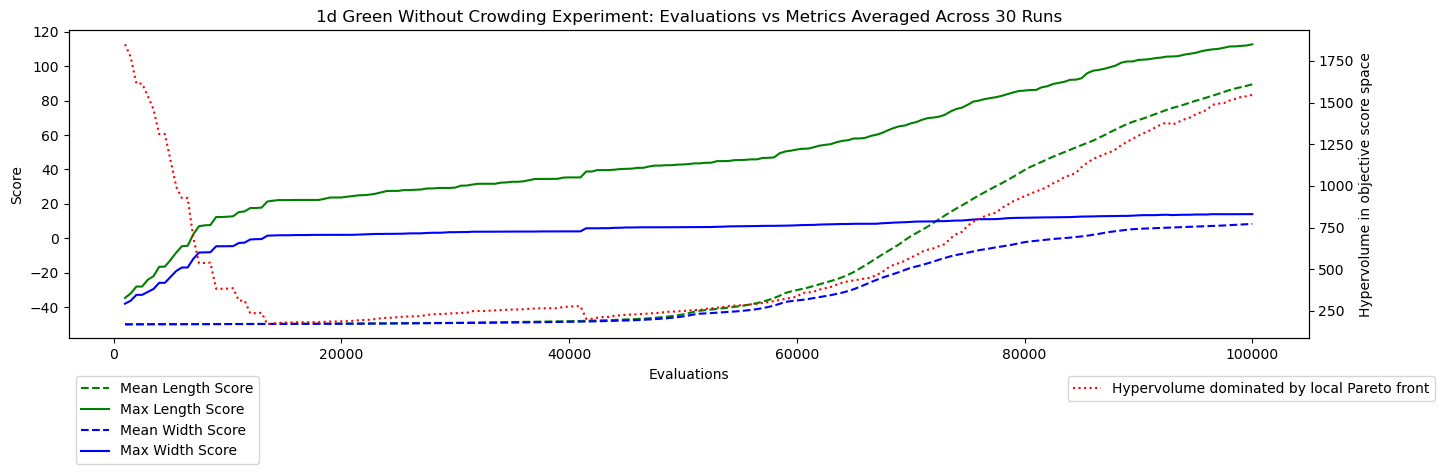

([88, 18], [94, 14], [114, 13], [126, 11])


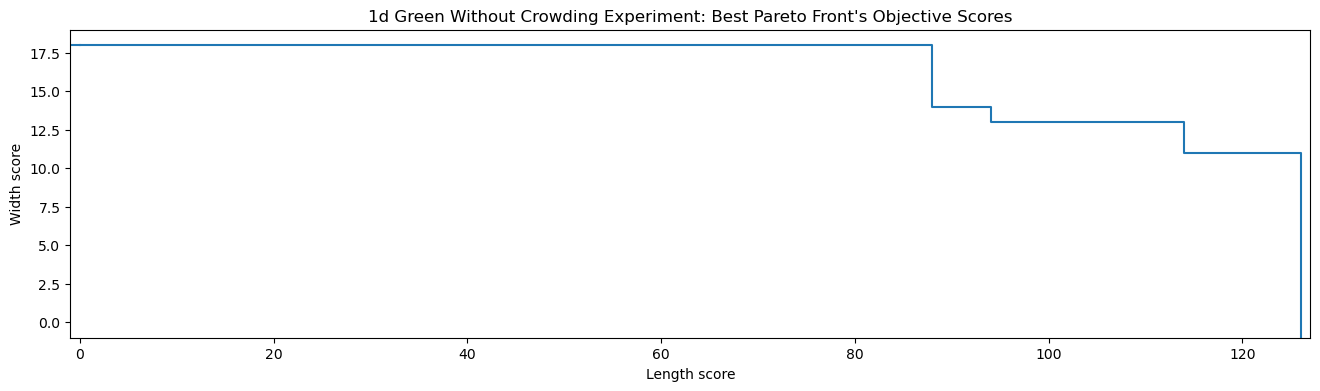

In [15]:
###############################
#                             #
# Without crowding experiment #
#                             #
###############################
import ast 

values_by_tuple = [[[] for _ in range(6)] for _ in range(199)]
with open('data/1d/green/no_crowding/statistics.txt', 'r') as f:
    for line in f.readlines():
        tuples_str = line.strip()[1:-1].split('), (')
        for idx, t in enumerate(tuples_str):
            values = t.split(',')
            for i in range(6):
                clean_value = re.sub(r'[^0-9.-]', '', values[i].strip())
                values_by_tuple[idx][i].append(float(clean_value))
                
averages_by_tuple = [
    tuple(sum(position_values) / len(position_values) for position_values in tuple_data)
    for tuple_data in values_by_tuple
]

# Local mean length score
no_crowding_mean_length = [i[2] for i in averages_by_tuple]

# Local max length score
no_crowding_max_length = [i[1] for i in averages_by_tuple]

# Local mean width score
no_crowding_mean_width = [i[4] for i in averages_by_tuple]

# Local max width score
no_crowding_max_width = [i[3] for i in averages_by_tuple]

# Local hypervolume
no_crowding_hypervolume = [i[5] for i in averages_by_tuple]

# Number of evaluations at each generation
no_crowding_evals = [int(i[0]) for i in averages_by_tuple]

plot_versus_evals(no_crowding_mean_length,
                  no_crowding_max_length,
                  no_crowding_mean_width,
                  no_crowding_max_width,
                  no_crowding_hypervolume,
                  no_crowding_evals,
                  '1d Green Without Crowding Experiment: Evaluations vs Metrics Averaged Across 30 Runs')


# Now, get the objective scores of the Pareto front with the greatest hypervolume.
# There are two likely scenarios:
# 1. You still have the LinearGenotype objects in memory.
# 2. You logged the objective scores, and do not have the LinearGenotype objects.
# Uncomment the appropriate code block below, and set the variables as instructed.
# Highlight the code block and press control + slash (ctrl+/) to uncomment.

# # Scenario 1: You have the LinearGenotype objects in memory.
# # Set this to the LinearGenotypes corresponding to your selected Pareto front.
# no_crowding_pareto_front = None
# no_crowding_pareto_scores = [individual.objectives for individual in no_crowding_pareto_front]

# # Scenario 2: You logged the objective scores but do not have the LinearGenotypes.
# # Set the two values below to lists containing the appropriate scores.
# # Make sure your lengths and widths are in the same order!
# # lengths[i] MUST be from the same individual on the front as widths[i]
with open('data/1d/green/no_crowding/pareto_front_data.txt', 'r') as f:
    for _ in range(17):  # Line 18 has the largest hypervolume
        f.readline()
    line_18 = f.readline().strip()

objective_data = line_18.split("[[", 1)[1].rsplit("]]", 1)[0]
objective_list = ast.literal_eval('[' + objective_data + ']')
no_crowding_lengths = [i[0] for i in objective_list]
no_crowding_widths = [i[1] for i in objective_list]
no_crowding_pareto_scores = zip(no_crowding_lengths, no_crowding_widths, strict=True)
print(objective_list)

plot_pareto_front(no_crowding_pareto_scores,
                  "1d Green Without Crowding Experiment: Best Pareto Front's Objective Scores")

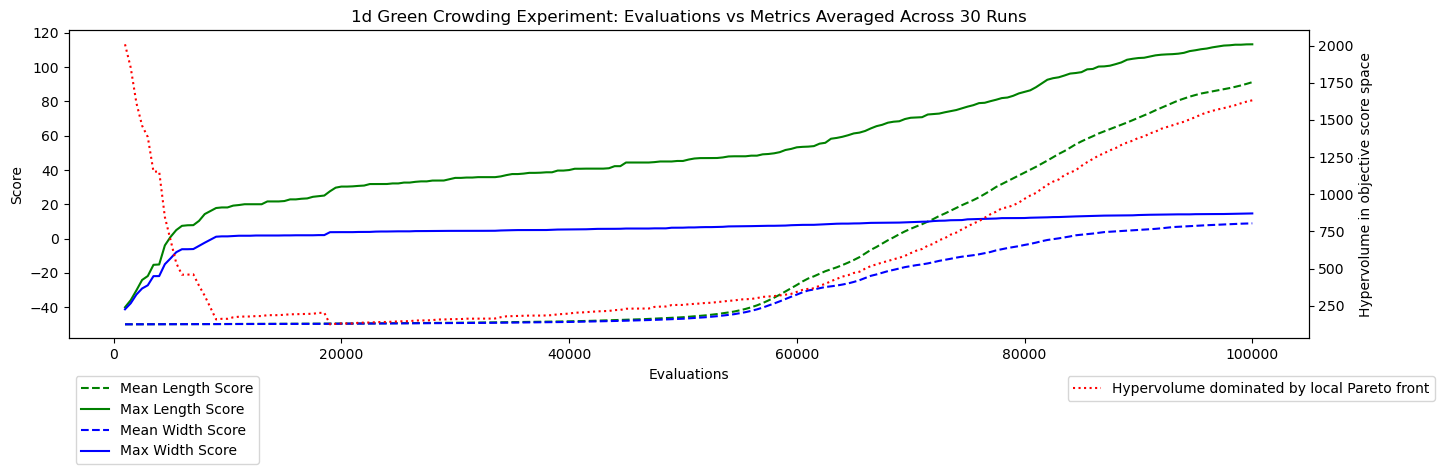

([128, 12], [94, 18], [94, 18], [117, 14], [104, 17], [104, 17], [94, 18], [104, 17], [104, 17], [104, 17], [94, 18], [104, 17], [104, 17], [104, 17])


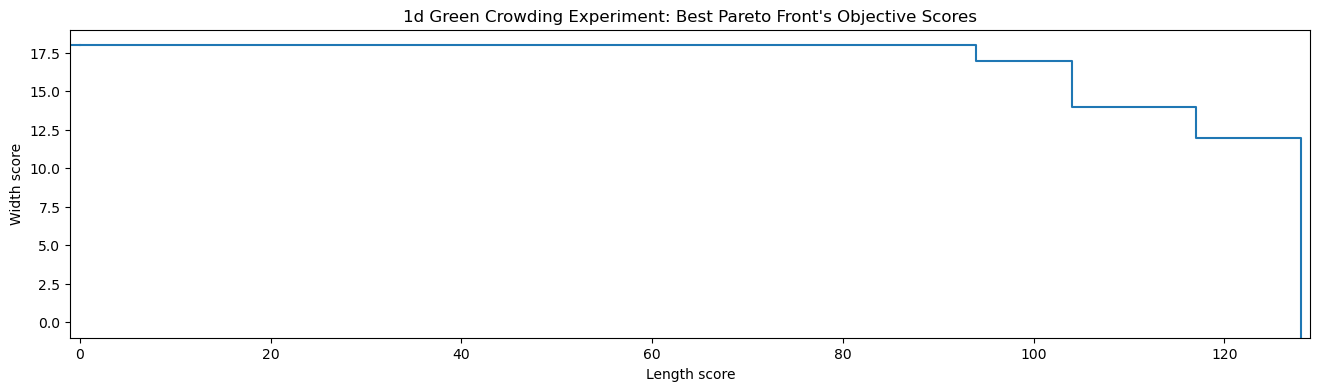

In [17]:
#######################
#                     #
# Crowding experiment #
#                     #
#######################
import ast 

values_by_tuple = [[[] for _ in range(6)] for _ in range(199)]
with open('data/1d/green/crowding/statistics.txt', 'r') as f:
    for line in f.readlines():
        tuples_str = line.strip()[1:-1].split('), (')
        for idx, t in enumerate(tuples_str):
            values = t.split(',')
            for i in range(6):
                clean_value = re.sub(r'[^0-9.-]', '', values[i].strip())
                values_by_tuple[idx][i].append(float(clean_value))
                
averages_by_tuple = [
    tuple(sum(position_values) / len(position_values) for position_values in tuple_data)
    for tuple_data in values_by_tuple
]

# Local mean length score
crowding_mean_length = [i[2] for i in averages_by_tuple]

# Local max length score
crowding_max_length = [i[1] for i in averages_by_tuple]

# Local mean width score
crowding_mean_width = [i[4] for i in averages_by_tuple]

# Local max width score
crowding_max_width = [i[3] for i in averages_by_tuple]

# Local hypervolume
crowding_hypervolume = [i[5] for i in averages_by_tuple]

# Number of evaluations at each generation
crowding_evals = [int(i[0]) for i in averages_by_tuple]

plot_versus_evals(crowding_mean_length,
                  crowding_max_length,
                  crowding_mean_width,
                  crowding_max_width,
                  crowding_hypervolume,
                  crowding_evals,
                  '1d Green Crowding Experiment: Evaluations vs Metrics Averaged Across 30 Runs')


# Now, get the objective scores of the Pareto front with the greatest hypervolume.
# There are two likely scenarios:
# 1. You still have the LinearGenotype objects in memory.
# 2. You logged the objective scores, and do not have the LinearGenotype objects.
# Uncomment the appropriate code block below, and set the variables as instructed.
# Highlight the code block and press control + slash (ctrl+/) to uncomment.

# # Scenario 1: You have the LinearGenotype objects in memory.
# # Set this to the LinearGenotypes corresponding to your selected Pareto front.
# crowding_pareto_front = None
# crowding_pareto_scores = [individual.objectives for individual in crowding_pareto_front]

# # Scenario 2: You logged the objective scores but do not have the LinearGenotypes.
# # Set the two values below to lists containing the appropriate scores.
# # Make sure your lengths and widths are in the same order!
# # lengths[i] MUST be from the same individual on the front as widths[i]
with open('data/1d/green/crowding/pareto_front_data.txt', 'r') as f:
    for _ in range(1):  # line 2 contains the largest hypervolume
        f.readline()
    line_2 = f.readline().strip()

objective_data = line_2.split("[[", 1)[1].rsplit("]]", 1)[0]
objective_list = ast.literal_eval('[' + objective_data + ']')

crowding_lengths = [i[0] for i in objective_list]
crowding_widths = [i[1] for i in objective_list]
crowding_pareto_scores = zip(crowding_lengths, crowding_widths, strict=True)
print(objective_list)

plot_pareto_front(crowding_pareto_scores,
                  "1d Green Crowding Experiment: Best Pareto Front's Objective Scores")

# Yellow Deliverable (Bonus for 5660 students, required for 6660 students)
If attempting the 1d yellow deliverable, perform your experiment and analysis below. You may add new cells, if you wish.

# Red Deliverable (Bonus)
If attempting the 1d red deliverable, perform your experiment and analysis below. You may add new cells, if you wish.